In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('clean_data.csv').set_index('NewDateTime')

df.head()

,Ave_Flot_Air_Flow,Ave_Flot_Level,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,% Silica Concentrate
NewDateTime,,,,,,,,,
2017-04-24 00:00:00,300.263166,383.982443,55.17,1979.589150,599.676489,400.017222,9.774028,1.753206,4.360000
2017-04-24 01:00:00,299.782402,386.049069,55.17,1758.466329,600.043100,400.484528,9.539246,1.754190,3.290000
2017-04-24 02:00:00,299.750052,385.250935,55.17,2379.752428,599.948406,400.325617,9.434227,1.756873,4.900000
2017-04-24 03:00:00,299.997522,389.635519,55.17,2287.130046,599.580383,399.801506,9.725607,1.727125,4.860153
2017-04-24 04:00:00,300.005220,387.810807,55.17,2291.789167,599.871217,399.567333,9.845198,1.633063,4.780898


### Creating Baseline Models: splitting the data, creating pipelines, and Cross-Validation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

array = df.values

X = array[:,:-1]
Y = array[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1271, 8), (546, 8), (1271,), (546,))

In [4]:
pipeline_lin = Pipeline([('scaler', StandardScaler()), ('Linear Regression', LinearRegression())])
pipeline_SVR = Pipeline([('scaler', StandardScaler()), ('SVR', SVR())])
pipeline_KNNReg = Pipeline([('scaler', StandardScaler()), ('KNN Regressor', KNeighborsRegressor())])
pipeline_RFR = Pipeline([('scaler', StandardScaler()), ('Random Forest Regressor', RandomForestRegressor())])
pipeline_GBR = Pipeline([('scaler', StandardScaler()), ('GBR', GradientBoostingRegressor())])
pipeline_SGDReg = Pipeline([('scaler', StandardScaler()), ('SGD Regressor', SGDRegressor())])

pipelines = [pipeline_lin, pipeline_SVR, pipeline_KNNReg, pipeline_RFR, pipeline_GBR, pipeline_SGDReg]

pipeline_dict = {0: 'Linear Regression', 1: 'SVR', 2: 'KNN Regressor', 3: 'Random Forest Regressor', 
                 4:'GBR', 5: 'SGD Regressor'}

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

results = []
std = []
for idx, val in enumerate(pipelines):
    kfold = KFold(n_splits = 10, random_state = 42)
    cv_results = cross_val_score(val, X_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_results)
    results.append(rmse_scores.mean())
    std.append(rmse_scores.std())
    print("{0}{1}: {2:.3f} ({3:.3f})".format(pipeline_dict[idx], ' RMSE Score', results[idx], std[idx]))

Linear Regression RMSE Score: 0.973 (0.075)
SVR RMSE Score: 0.992 (0.102)
KNN Regressor RMSE Score: 1.007 (0.078)
Random Forest Regressor RMSE Score: 0.971 (0.075)
GBR RMSE Score: 0.957 (0.065)
SGD Regressor RMSE Score: 0.975 (0.074)


C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Adam\Anaconda3\lib\site-pac

The Gradient Boosting Regressor performs the best using a scaled version of the data. We will now build the regression algorithm using the Gradient Boosting Regressor.

### Validate Model using the test data 

In [53]:
scaler = StandardScaler().fit(X_train)
X_tr_scale = scaler.transform(X_train)
X_te_scale = scaler.transform(X_test)

model_GBR = GradientBoostingRegressor()

model_GBR.fit(X_tr_scale, y_train)

y_pred_base = model_GBR.predict(X_te_scale)
mse = mean_squared_error(y_test, y_pred_base)
rmse = np.sqrt(mse)
print('RMSE: {0:.3f}'.format(rmse))
print('R2: {0:.3f}'.format(model_GBR.score(X_te_scale, y_test)))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

RMSE: 0.913
R2: 0.221


In [42]:
def evaluate(predictions, test_data):
    errors = abs(predictions - test_data)
    mape = 100 * np.mean(errors / test_data)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))
    
    return accuracy

In [54]:
base_accuracy = evaluate(y_pred_base, y_test)

Model Performance
Average Error: 0.7170
Accuracy = 62.24%


### Using GridSearchCV to tune our Model

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4], 
              'learning_rate': [0.1, 0.01, 0.001],
              'min_samples_split': [2, 4, 6], 
              'min_samples_leaf': [1, 3, 5]}

model = GradientBoostingRegressor()

kfold = KFold(n_splits = 10, random_state = 42)
grid_search = GridSearchCV(model, param_grid, cv = kfold, scoring = 'neg_mean_squared_error')
grid_search.fit(X_tr_scale, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_depth': [2, 3, 4], 'learning_rate': [0.1, 0.01, 0.001], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [61]:
grid_search.best_params_
np.sqrt(-grid_search.best_score_)

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

0.9485267985205853

### Finalize and Validate Model with the Best Estimator previously discovered during GridSearchCV

In [62]:
from sklearn.metrics import mean_squared_error

Final_Model = grid_search.best_estimator_ 
Final_Model.fit(X_tr_scale, y_train)

y_pred_final = Final_Model.predict(X_te_scale)
Final_mse = mean_squared_error(y_test, y_pred_final)
Final_rmse = np.sqrt(Final_mse)
print('RMSE: {0:.3f}'.format(Final_rmse))
print('R2: {0:.3f}'.format(Final_Model.score(X_te_scale, y_test)))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

RMSE: 0.907
R2: 0.232


In [64]:
final_accuracy = evaluate(y_pred_final, y_test)

Model Performance
Average Error: 0.7045
Accuracy = 62.89%


In [66]:
print('Improvement of {:0.2f}%.'.format(final_accuracy - base_accuracy))

Improvement of 0.65%.


In [69]:
# Comparing the raw predicted values and the corresponding test data
compare = pd.DataFrame({'Prediction': y_pred_final, 'Test Data': y_test})
compare.head(20)

,Prediction,Test Data
0,1.790057,2.05
1,1.399240,0.99
2,2.184656,2.93
3,2.566644,4.79
4,2.366381,1.69
5,2.471677,1.85
6,3.373766,2.09
7,1.506497,1.08
8,1.827573,1.19
9,1.607190,1.64


C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


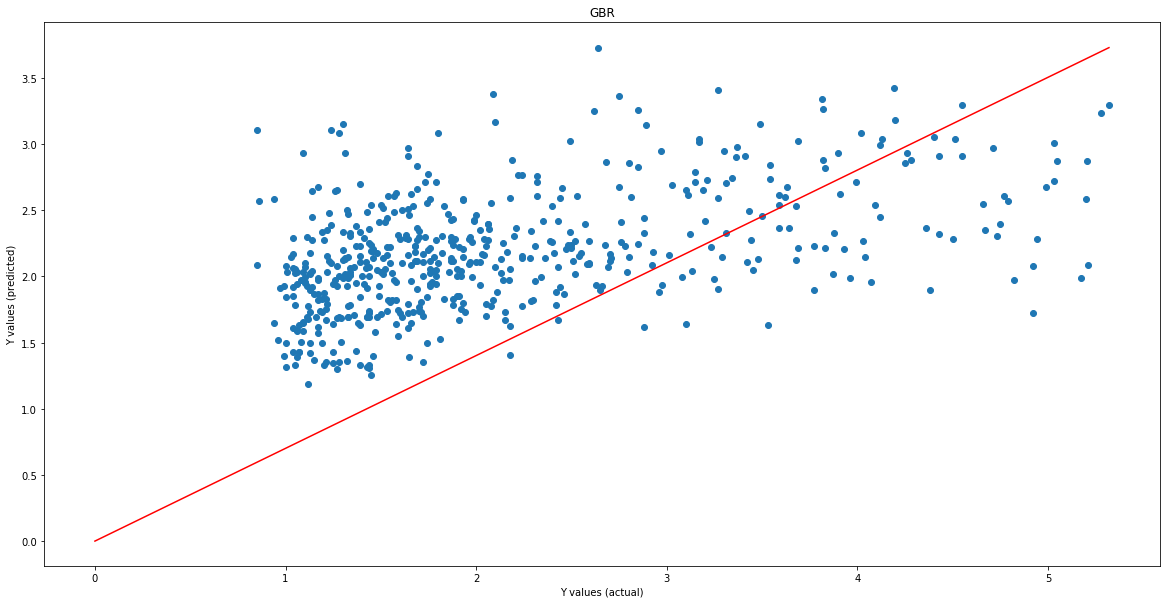

In [71]:
# GBR performance 
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
ax.set(title = 'GBR', xlabel = 'Y values (actual)', ylabel = 'Y values (predicted)')
ax.scatter(y_test, y_pred_final)
ax.plot([0, max(y_test)], [0, max(y_pred_final)], color = 'r')
fig.show();